In [11]:
import spacy
import scispacy
import pandas as pd
import en_core_sci_lg
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.tokens import Doc
from spacy.tokens import DocBin
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS, HYPHENS
from spacy.util import compile_infix_regex
from gensim.models import Word2Vec, KeyedVectors


In [12]:
df1 = pd.read_csv ('data_files/positive_kinase_activity', sep='\t')
df1['Label'] = 1

df2 = pd.read_csv ('data_files/neg_sentences_kinase_activity_with_kinase.txt', sep='\t', header=None)
df2 = df2.rename(columns={0: "id", 1: "Sentence"})
df2['Label'] = 0

df = pd.concat([df1[['Sentence', 'Label']], df2[['Sentence', 'Label']]], ignore_index=True)
print(df.head())

                                            Sentence  Label
0  In mammalian cells subjected to ER stress, we ...      1
1  To address the role of C. elegans PEK in trans...      1
2  We show that recombinant CePEK phosphorylates ...      1
3                       eIF-2α kinase assay in vitro      1
4  Following a similar regimen described for the ...      1


In [13]:
text_docs = df['Sentence'].astype(str).values.tolist()
print(len(text_docs))
import random
random.shuffle(text_docs)

nlp = spacy.load("en_core_sci_md")

docs = list(nlp.pipe(text_docs[:4000]))

print(len(docs))

1399
1399


In [14]:
from utils.print_tree import print_tree

corpus = []
for i in range(0, len(docs)):
    
    node_list = []
    edge_list = []
    sent_len = i
    #print(sent_len, ":", docs[sent_len])
    for sent in docs[sent_len].sents:
        for token in sent:
            node_list.append([token, True])
        print_tree(sent.root, node_list, edge_list, 0)    
        break

    texts = []
    for edge in edge_list:
        #print(node)
        texts.append(edge[0].text.lower())
        texts.append(edge[1].text.lower())
            
    corpus.append(texts)

print(len(corpus))

1399


In [15]:
dimension = 2
window = 2
word2vec0 = Word2Vec(corpus, min_count=1, vector_size=dimension, window=window, sg=1)
print(word2vec0.wv.get_vector('kinase'))
print(word2vec0.wv.get_vector('kinases'))


[1.8666768 0.7579255]
[ 2.176313   -0.09691479]


In [16]:
embedding0 = pd.DataFrame(columns=['d0', 'd1'])
for token in word2vec0.wv.index_to_key:
    embedding0.loc[token] = word2vec0.wv.get_vector(token)
embedding0

d0        d1
                   2.220554 -0.538850
kinase             1.866677  0.757926
kinases            2.176313 -0.096915
protein            2.081547  0.283952
domain             1.892923  0.980656
...                     ...       ...
rab5               0.013581 -0.082525
pi(3)p-binding     0.135512 -0.234525
o76360|egl4_caeel -0.007460  0.357924
2|egl4_caeel       0.116466 -0.039268
gas                0.004326 -0.358726

[6938 rows x 2 columns]

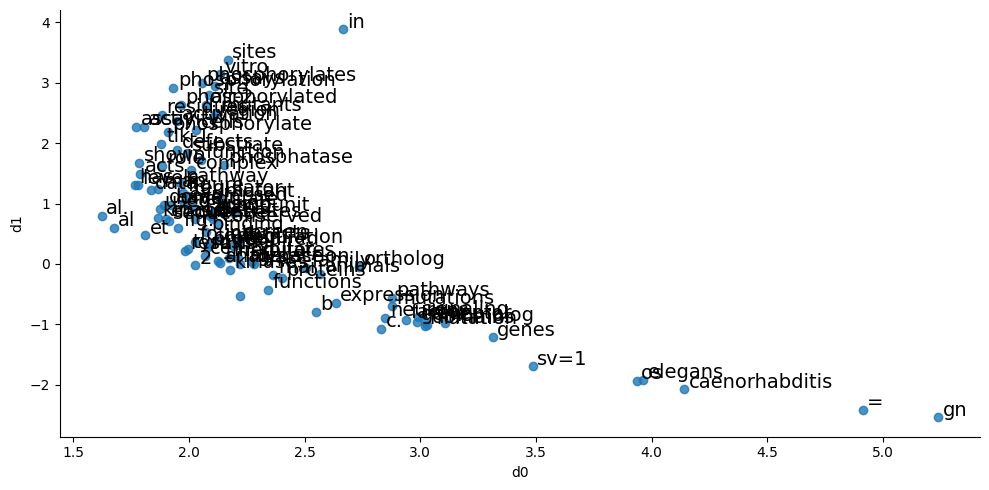

In [18]:
plot_amount = 100
sns.lmplot(data=embedding0[:plot_amount], x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding0[:plot_amount].iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), size=14)
plt.tight_layout()